# WOW! I can denoise & enhance solar images with the *à trous* wavelet transform

In the notes below, equation numbers refer to

Auchère, F., Soubrié, E., Pelouze, G., Buchlin, É. 2023, Image Enhancement With Wavelets Optimized Whitening, A&A, 670, id.A66, doi:[10.1051/0004-6361/202245345](https://ui.adsabs.harvard.edu/link_gateway/2023A&A...670A..66A/doi:10.1051/0004-6361/202245345)

In [1]:
# Just a convenience plotting function
def two_plots(images, titles, norms):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img, title, norm in zip(axes.flatten(), images, titles, norms):
        ax.imshow(img[roi], origin='lower', norm=norm, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()

# Computes the peak signal-to-noise ratio
def psnr(reference, image):
    return 10*np.log10(np.max(reference)**2/np.mean((reference - image)**2))

## 1. Denoising

Let's first read an EUI HRI_EUV L2 FITS file (2048 x 2048 pixels) and display it

(-0.5, 2047.5, -0.5, 2047.5)

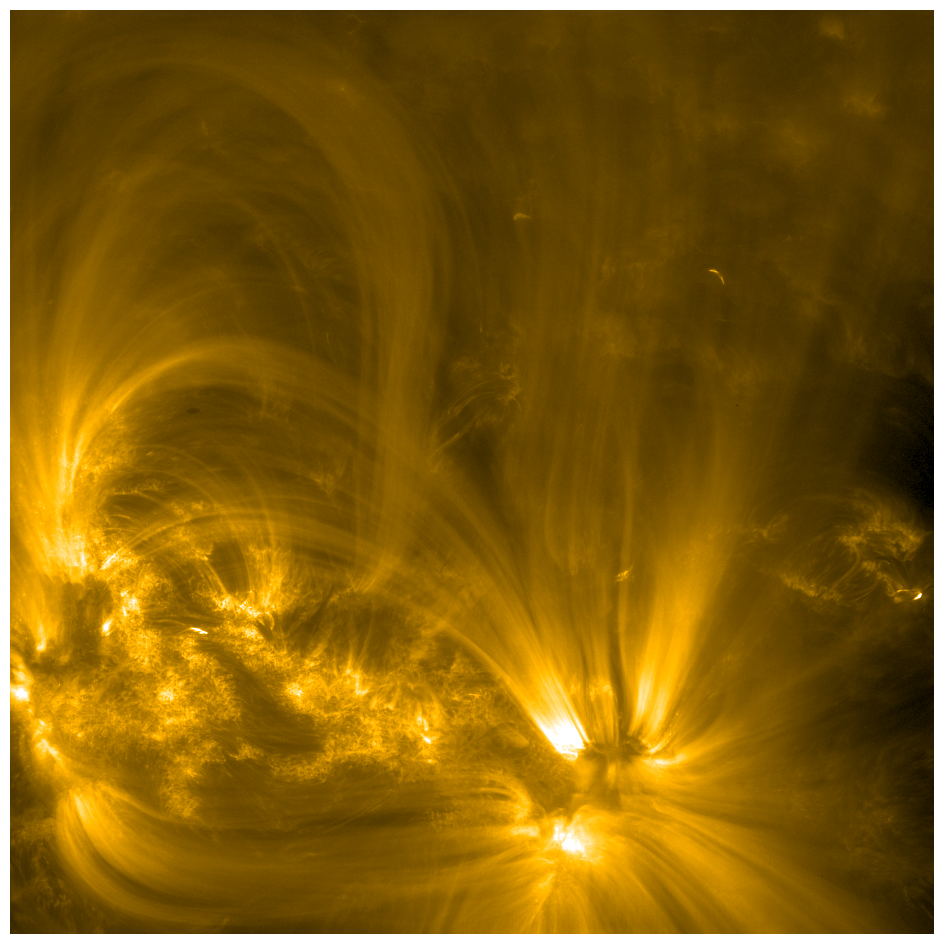

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, PowerStretch, PercentileInterval
from sunpy.visualization.colormaps import cm

with fits.open('solo_L2_eui-hrieuv174-image_20220317T040257234_V02.fits') as hdu_list:
    header = hdu_list[-1].header
    image = hdu_list[-1].data

image *= header['XPOSURE']  # L2 data is normalized to the exposure time. We will need values in DN, not DN/s later on.

gamma = 2.0
norm = ImageNormalize(image, stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.8))
fig, ax = plt.subplots(figsize=(12, 12))
cmap = plt.get_cmap('solar orbiterhri_euv174')
ax.imshow(image, norm=norm, origin='lower', cmap=cmap)
ax.axis('off')

In [3]:
print(f"Image taken at {header['DSUN_AU']:.2f} AU")

Image taken at 0.38 AU


The distance doesn't matter here. Just to brag that the equivalent resolution at 1 AU is ~0.38" (two pixels). EUI rocks!

Then let's create a list of denoising coefficients

In [4]:
denoise_sigma = [5, 3]

They correspond to the $n_s$ of Equation 10. For denoising, the absolute value of the coefficients at each scale is compared to $n_s\sigma_s=n_s\sigma\sigma_s^1$, $\sigma$ being the standard deviation of the noise in the image (assumed here to be Gaussian, see later for Poisson noise), and $\sigma_s^1$ being the standard deviation expected at scale $s$ for Normal Gaussian noise.

Denoising is performed by either *hard-thresholding* in which case the non-significant coefficents are set to 0 (Equation 11) or *soft-thresholding*, in which case the coefficients are weighted by their probability of chance occurrence (Equation 12).

Noise typical lives in the first two scales. To denoise only in the first scale, use, *e.g.*, denoise_sigma = [5,].

The choice of ```denoise_sigma``` defines the probability above which coefficients are considered significant. $n_0=5$ and $n_1=3$ in ```denoise_sigma``` correspond respectively to probabilities of >99.99% and 99.73%. It is to be noted that the pixels are treated independently. Therefore, while the probability of a single pixel to be above, *e.g.* $3\sigma$ by chance is very small, about 10000 will pass the test in the entire 2k x 2k image.

We now instantiate a wavelet transform object and compute the coefficients by calling it with ```image``` and the desired number of scales as parameters. In this example, since ```denoise_sigma``` has two elements, the transform is computed for two scales, plus the final smoothed image. By definition, the input is equal to the sum of the coefficients, plus the final smoothed image (Equation 6).

In [5]:
from watroo import AtrousTransform
transform = AtrousTransform()
coefficients = transform(image, len(denoise_sigma))

### 1.1. Automatic denoising
#### 1.1.1. Gaussian noise

The coefficients are denoised by calling their ```denoise``` method with the ```denoise_sigma``` list as parameter, and the ```soft_threshold``` optional parameter set to ```False``` for hard thresholding

In [6]:
# coefficients.data is a ndarray that contains the coefficients proper
coefficients.denoise(denoise_sigma, soft_threshold=False)

In this case, since we did not provide any information about the noise in the data, the code assumes it to be Gaussian, and estimates its standard deviation $\sigma$ from the median of the absolute value of the coefficients in the first scale:
    $\sigma=med(|w1,k|)/0.6745$

The denoised image is then obtained by summing the coefficients

In [7]:
import numpy as np
# coeffcients accepts numpy operations
denoised_gaussian_hard = np.sum(coefficients, axis=0)
# which is equivalent to
denoised_gaussian_hard = coefficients.data.sum(axis=0)

The same result could have been obtained directly using the ```denoise``` convenience function

In [8]:
from watroo import denoise
denoised_gaussian_hard = denoise(image, denoise_sigma, soft_threshold=False)

We can display the result, zooming in on a 150 x 150 pixels region of interest and compare with the input

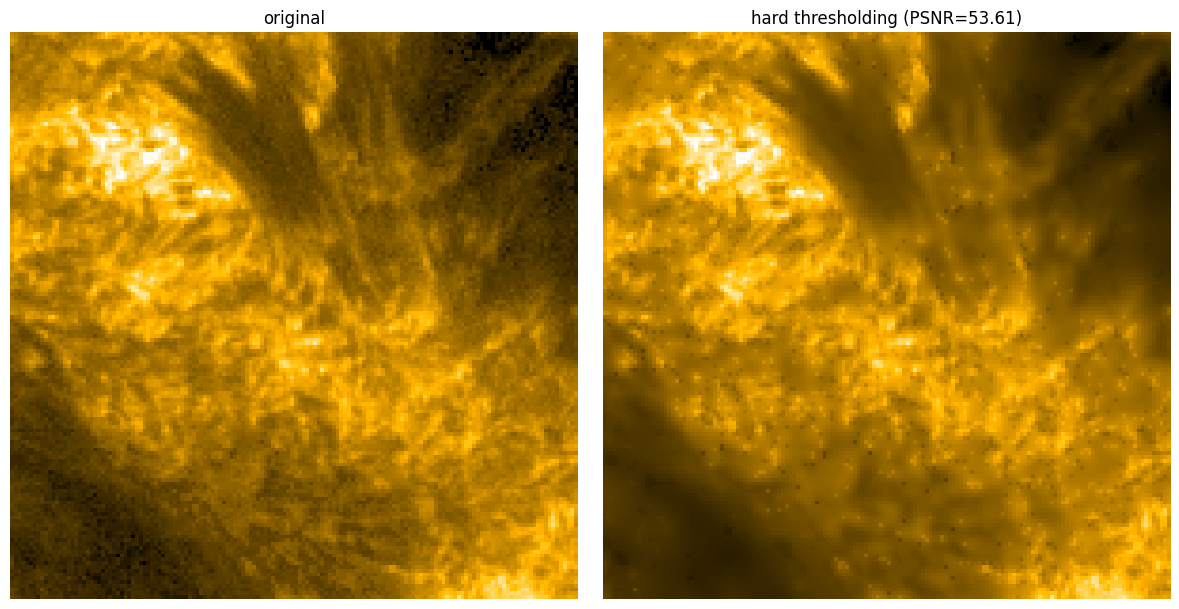

In [9]:
roi = slice(550, 700), slice(500, 650)  # define a region of interest

norm = ImageNormalize(denoised_gaussian_hard[roi], stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.9))

two_plots([image, denoised_gaussian_hard],
          ['original', f'hard thresholding (PSNR={psnr(image, denoised_gaussian_hard):.2f})'],
          [norm, norm])

The grainy regions are smoothed out, and bright details preserved, but fainter features are bloated or lost. The Peak Signal to Noise (PSNR) ratio is given as an indicative measure of the relative performance of various denoising options. The 'noise (N)' in the PSNR is the difference between the original and the denoised images. Higher values indicate better denoising performance. Note that it is not an absolute measure, since zero denoising corresponds to infinite PSNR...
Let's now try soft thresholding (the default for the ```denoise```convenience function)

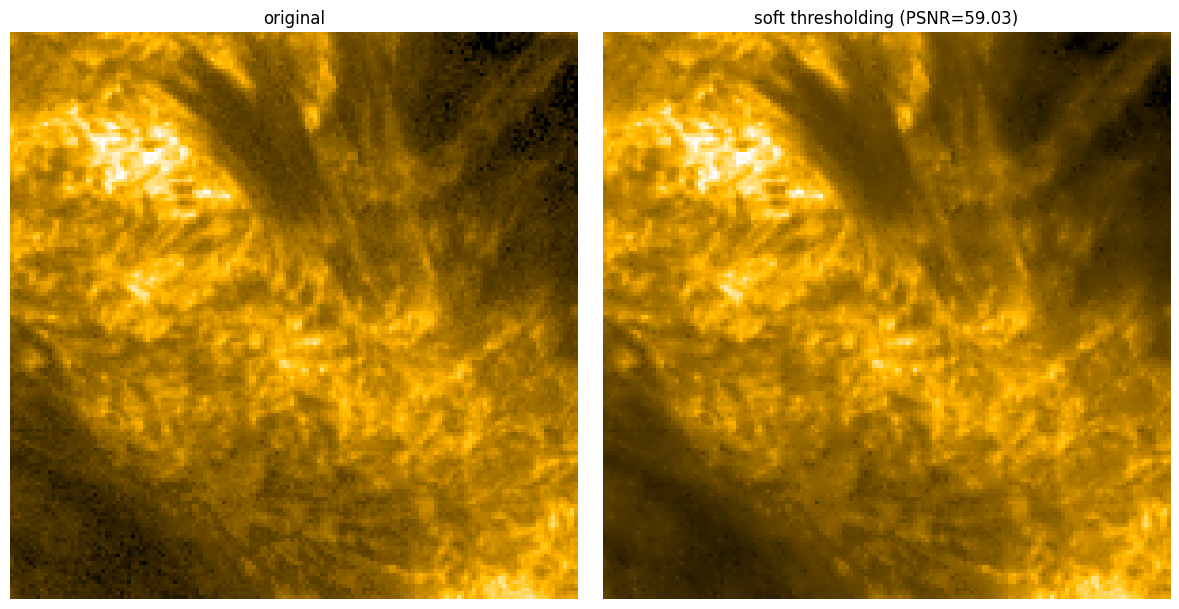

In [10]:
# denoise the input image with soft-thresholding (the default)
denoised_gaussian_soft = denoise(image, denoise_sigma)

two_plots([image, denoised_gaussian_soft],
          ['original', f'soft thresholding (PSNR={psnr(image, denoised_gaussian_soft):.2f})'],
          [norm, norm])

Soft-thresholding does a better job at preserving small scale details tha, hard thresholding (higher PSNR) that otherwise tend to be flattened out.

#### 1.1.2. Poisson noise
The noise in the EUI data (as well as in many astronomical images) is a combination of detector read noise, which is typically Gaussian, and Photon shot noise, which is Poissonian. Except in very faint regions, photon shot noise dominates. As opposed to read noise, photon shot noise is a function of the intensity and is thus variable spatially. There are two ways to account for Poissonian statistics.

The first one is to use the Anscombe transform (Equation 13)

 $T(I) = \sqrt(I + 3/8)$

which results in data with Gaussian noise of unit variance for numbers of counts greater than about ten. The Anscombe transform thus brings us back to the case of Gaussian noise. The data is transformed back to the original scale of intensity after denoising.

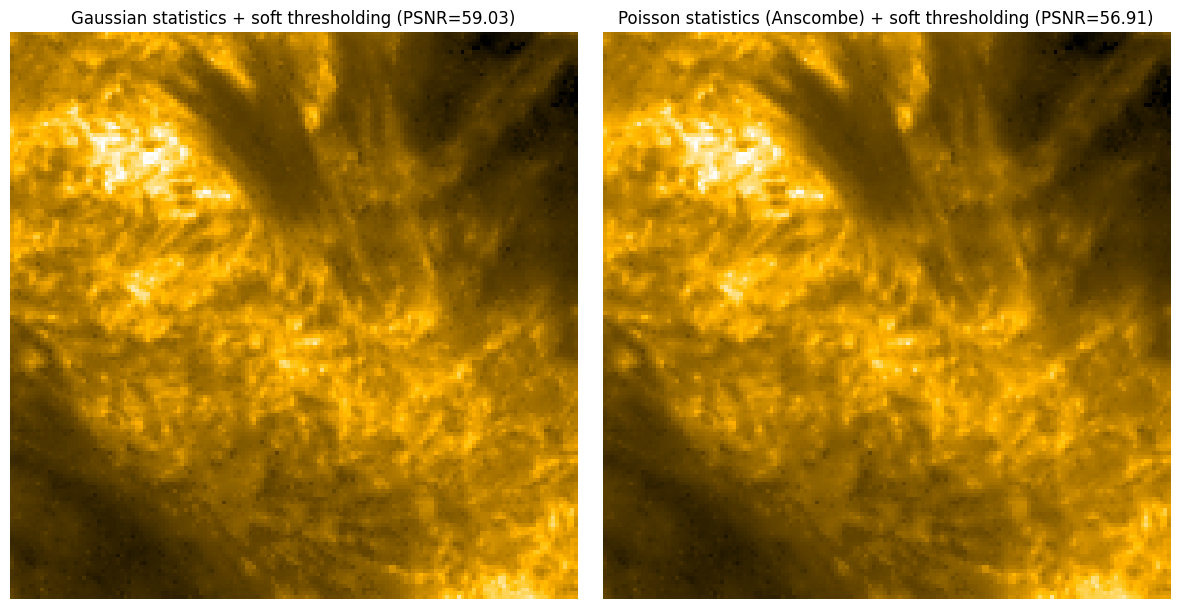

In [11]:
denoised_anscombe_soft = denoise(image, denoise_sigma, anscombe=True)

var = np.var(image[roi] - denoised_anscombe_soft[roi])

two_plots([denoised_gaussian_soft, denoised_anscombe_soft],
          [f'Gaussian statistics + soft thresholding (PSNR={psnr(image, denoised_gaussian_soft):.2f})',
           f'Poisson statistics (Anscombe) + soft thresholding (PSNR={psnr(image, denoised_anscombe_soft):.2f})'],
          [norm, norm])

The results are very similar, but the image on the right-hand side is slightly more denoised (lower PSNR). Note that in this case the standard deviation of the noise in the data is still computed from the data itself, albeit after transformation.

### 1.2. Manual denoising

We can easily account for the spatial dependence of the shot noise by replacing $\sigma_s$ (Equations 10, 11, 12) by a spatially variable local standard deviation $\sigma_s(k)$, which can be estimated if the detector gain $g$ and read noise standard deviation $r$ are known, with

$\sigma_s(k) = \sqrt(gI + r^2)$

For HRI_EUV, the gain is 5.28 DN/photon, and the read noise is 1.5 DN. We can then compute a map of the noise in the image. It is important to note that the shot noise must be computed from the number of detected photons, **hence the importance of having multiplied the L2 data (in DN/s) by the exposure time** (see the beginning of Section 1).

In [12]:
gain = 5.28
read_noise_std = 1.5

noise_map = np.sqrt(gain*image + read_noise_std**2)

This map can then be passed to the ```denoise``` function, which will use it instead of using an automatic Gaussian approximation.

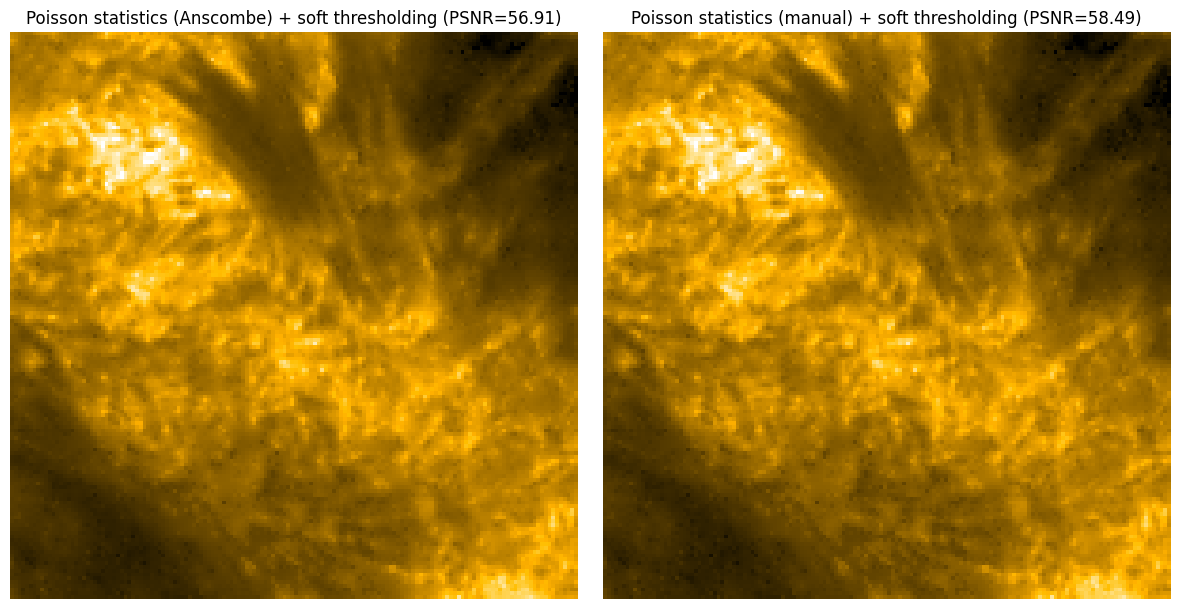

In [13]:
denoised_manual_soft = denoise(image, denoise_sigma, noise=noise_map)

var = np.var(image[roi] - denoised_manual_soft[roi])

two_plots([denoised_anscombe_soft, denoised_manual_soft],
          [f'Poisson statistics (Anscombe) + soft thresholding (PSNR={psnr(image, denoised_anscombe_soft):.2f})',
           f'Poisson statistics (manual) + soft thresholding (PSNR={psnr(image, denoised_manual_soft):.2f})'],
          [norm, norm])

Manual denoising is formally the most accurate procedure and provides a slightly sharper output (higher PSNR). The similarity of the results shows that the Anscombe transform provides a robust denoising if the photometry is unknown.

Finally, let's emphasize again that the choice of denoising coefficients is arbitrary and is a compromise between how much noise has to be removed *vs.* how much detail can be lost.

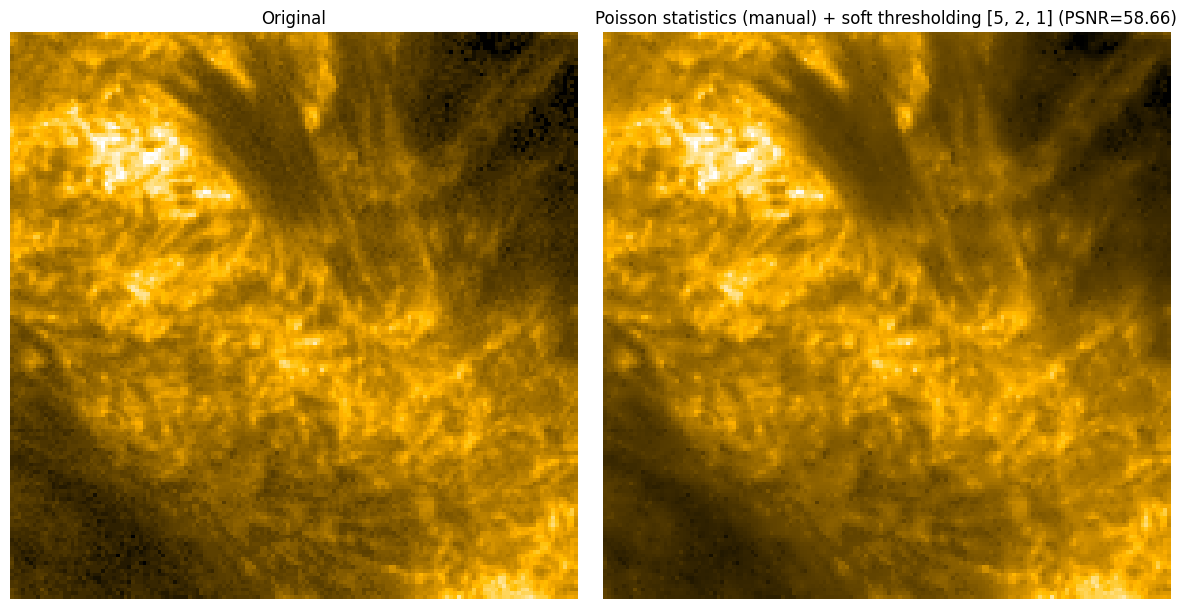

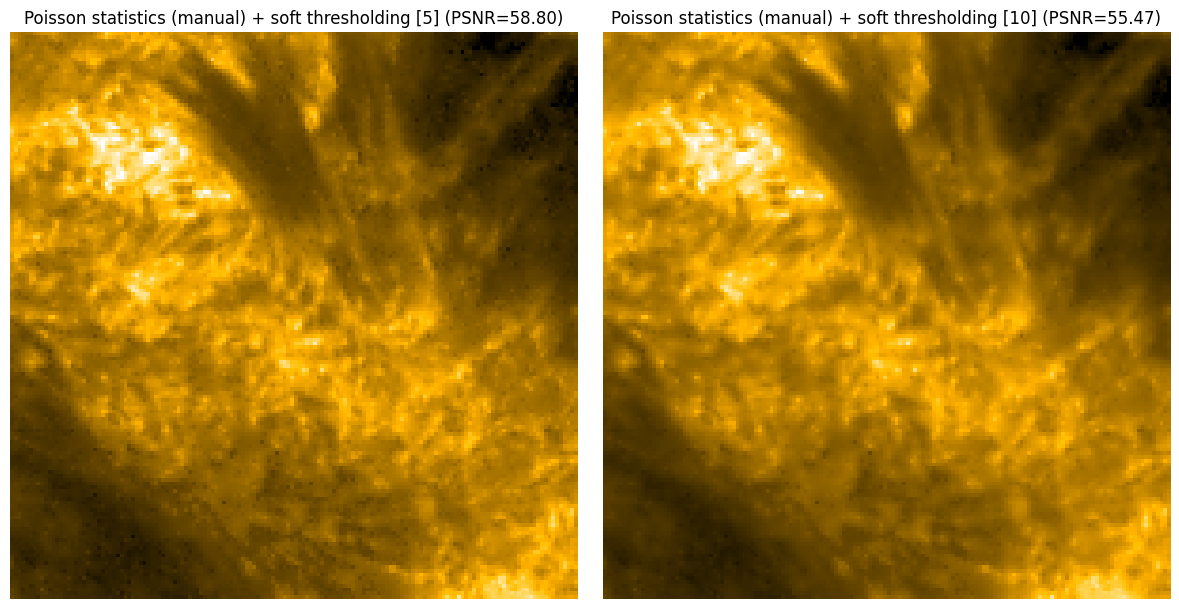

In [14]:
denoised_manual_soft_three_scales_521 = denoise(image, [5, 2, 1], noise=noise_map)
denoised_manual_soft_one_scale_5 = denoise(image, [5,], noise=noise_map)
denoised_manual_soft_one_scale_10 = denoise(image, [10,], noise=noise_map)

two_plots([image, denoised_manual_soft_three_scales_521],
          ['Original',
           f'Poisson statistics (manual) + soft thresholding [5, 2, 1] (PSNR={psnr(image, denoised_manual_soft_three_scales_521):.2f})'],
          [norm, norm])
two_plots([denoised_manual_soft_one_scale_5, denoised_manual_soft_one_scale_10],
          [f'Poisson statistics (manual) + soft thresholding [5] (PSNR={psnr(image, denoised_manual_soft_one_scale_5):.2f})',
           f'Poisson statistics (manual) + soft thresholding [10] (PSNR={psnr(image, denoised_manual_soft_one_scale_10):.2f})'],
          [norm, norm])

### 1.2. Temporal denoising

In a sequence of images, it is possible to use the temporal dimension as an additional source of information for denoising. The *à trous* transform works in n-dimensions and a cube of images can thus be denoised in exactly the same way as a single frame.

No example is provided here, try it!

# 2. Enhancement with Wavelets Optimized Whitening (WOW)

The WOW package provides two ways of processing images with the WOW! algorithm:
* The `wow` function that can be used in Python programs
* The `wow` executable that can be run from the command line

### 2.1 In a Python program

In [15]:
from wow import wow

First, the standard enhancement, as simple as

In [16]:
wow_image = wow(image)

A 512 x 512 enlargement of the output looks like this

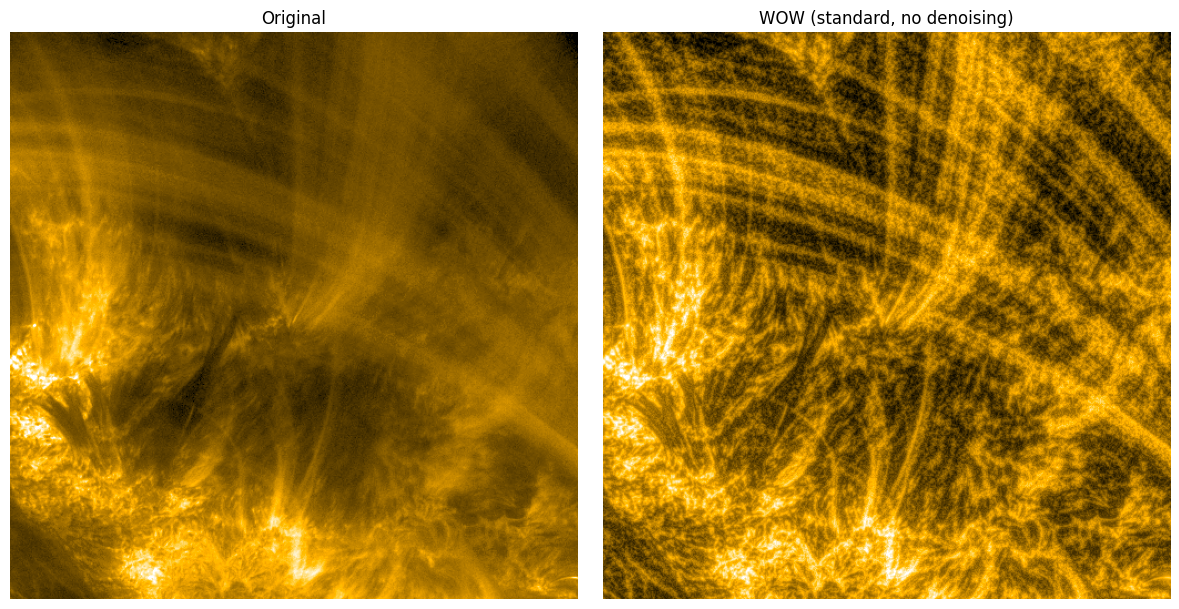

In [17]:
roi = slice(512, 1024), slice(512, 1024)

norm = ImageNormalize(image[roi], stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.9))
norm_wow = ImageNormalize(wow_image[roi], stretch=LinearStretch(), interval=PercentileInterval(99.9))

two_plots([image, wow_image],
          ['Original', 'WOW (standard, no denoising)'],
          [norm, norm_wow])

It is important to note that the original image is $\gamma$-stretched, while the WOW image is displayed in linear scale. By definition of the whitening procedure, the signal variance is equalized at all scales and all positions, which reduces the amplitude of the large scale variations and increases the amplitude of the small scal variations.

Expert users who want to manipulate the wavelet coefficients can do so by using the ```wow``` function of the ``watroo`` package (which is used by the ```wow``` package)

```python
from watroo import wow
wow_image, coefficients = wow(image)
```
In that case, the ```wow``` function returns a 2-tuple that contains the filtered image and the corresponding wavelet coefficients.

Since WOW uses the *à trous* wavelet transform, denoising can be performed prior to whitening

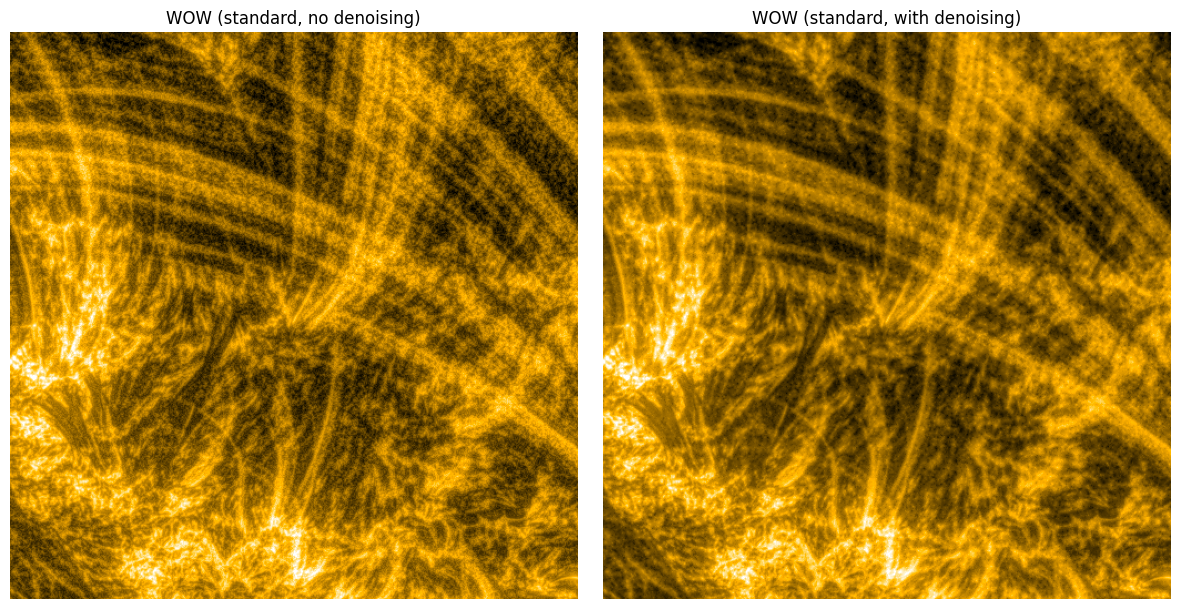

In [18]:
wow_image_denoised = wow(image, denoise_coefficients=denoise_sigma, noise=noise_map)

norm_wow_denoised = ImageNormalize(wow_image_denoised[roi], stretch=LinearStretch(), interval=PercentileInterval(99.9))

two_plots([wow_image, wow_image_denoised],
          ['WOW (standard, no denoising)', 'WOW (standard, with denoising)'],
          [norm_wow, norm_wow_denoised])

The edge-aware (or bilateral) variant uses a bilateral filter instead of the regular convolution product to reduce halos around bright features. By default, the ```bilateral```parameter is set to ```None```, which results in standard enhancement. Bilateral enhancement is triggered by setting ```bilateral=1```. Other values are experimental, **do not use anything else**.

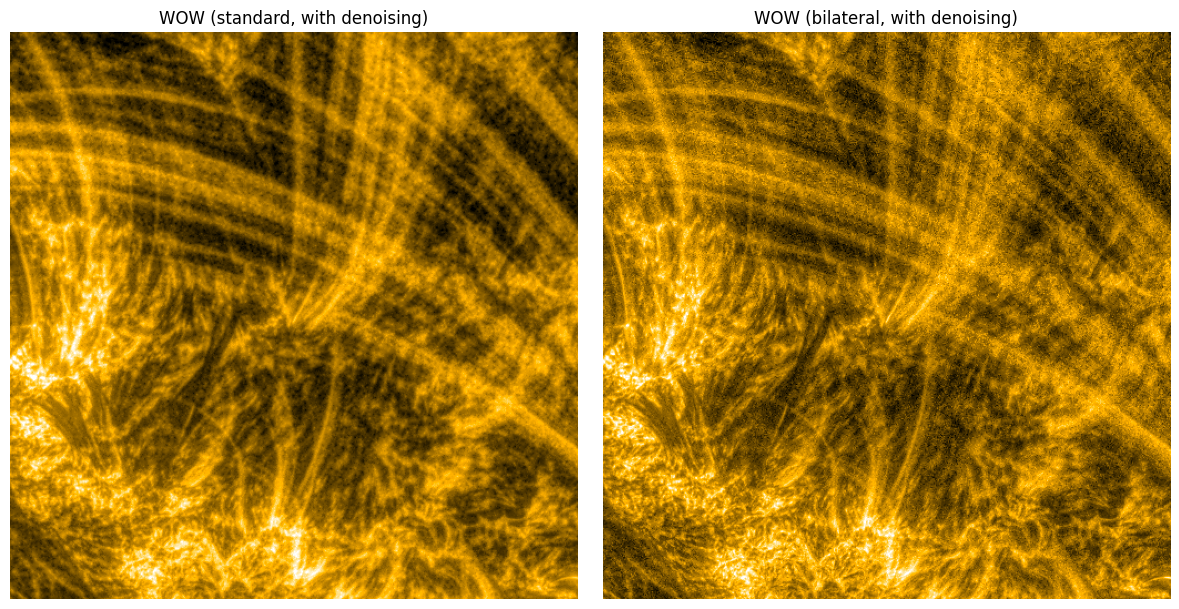

In [19]:
wow_image_bilateral_denoised = wow(image, denoise_coefficients=denoise_sigma, noise=noise_map, bilateral=1)

norm_wow_bilateral = ImageNormalize(wow_image_bilateral_denoised[roi], stretch=LinearStretch(), interval=PercentileInterval(99.9))

two_plots([wow_image_denoised, wow_image_bilateral_denoised],
          ['WOW (standard, with denoising)', 'WOW (bilateral, with denoising)'],
          [norm_wow_denoised, norm_wow_bilateral])

While it is a heresy with respect to the original idea of not having user adjustable ad-hoc parameters, the ```wow``` function includes tha capability to merge the output with a $\gamma$-stretched version of the input, controlled by the parameter ```gamma```  (3.2 by default). The weight of the $\gamma$-stretched image in the mix is adjusted *via* the parameter ```h```, which is set to 0 by default (pure WOW). Setting ```h=1``` will result in a non-enhanced, but denoised image.

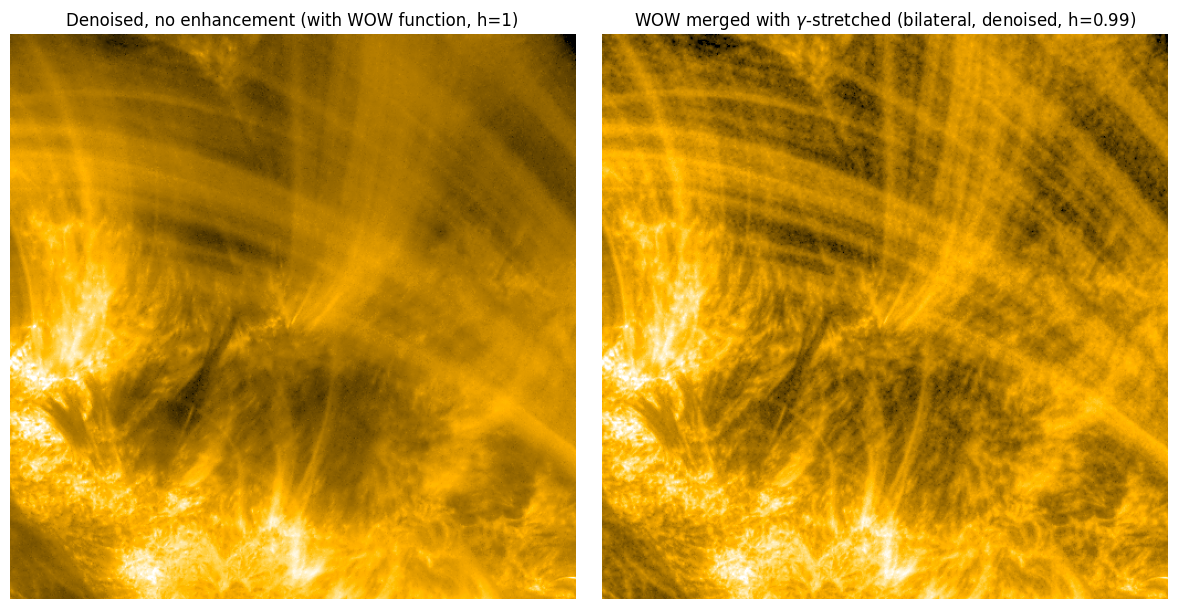

In [20]:
image_denoised = wow(image, denoise_coefficients=denoise_sigma, noise=noise_map, h=1)
wow_image_gamma_denoised = wow(image, denoise_coefficients=denoise_sigma, noise=noise_map, h=0.99, gamma=2.4)

gamma = 2
norm = ImageNormalize(image_denoised[roi], stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.9))
norm_wow_gamma = ImageNormalize(wow_image_gamma_denoised[roi], stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.9))

two_plots([image_denoised, wow_image_gamma_denoised],
          ['Denoised, no enhancement (with WOW function, h=1)', 'WOW merged with $\gamma$-stretched (bilateral, denoised, h=0.99)'],
          [norm, norm_wow_gamma])

### 2.2. The wow executable

The `wow` executable can be called from the command line to produce movies from a sequence of files, directories or glob patterns. Help on the available parameters can be obtained with

```shell
wow --help

usage: WOW! [-h] (--source SOURCE | --selektor Selektor query [Selektor query ...]) [-o OUTPUT] [-d DENOISE [DENOISE ...]] [-nb] [-ns N_SCALES] [-gw GAMMA_WEIGHT] [-g GAMMA] [-nw]
            [-t] [-roi ROI ROI ROI ROI] [-r REGISTER] [-ne] [-fps FRAME_RATE] [-crf CRF] [-np N_PROCS] [-nc] [-fn FIRST_N] [-i INTERVAL INTERVAL] [-rb REBIN] [-tf]

Processes a sequence of files with Wavelets Optimized Whitening and encodes the frames to video.

optional arguments:
  -h, --help            show this help message and exit
  --source SOURCE       List of files, directories or glob patterns
  --selektor Selektor query [Selektor query ...]
                        Queries Selektor for EUI observations
  -o OUTPUT, --output OUTPUT
                        Output filename. Frames are saved in its base directory.
  -d DENOISE [DENOISE ...], --denoise DENOISE [DENOISE ...]
                        De-noising coefficients
  -nb, --no_bilateral   Do not use edge-aware (bilateral) transform
  -ns N_SCALES, --n_scales N_SCALES
                        Number of wavelet scales
  -gw GAMMA_WEIGHT, --gamma_weight GAMMA_WEIGHT
                        Weight of gamma-stretched image
  -g GAMMA, --gamma GAMMA
                        Gamma exponent
  -nw, --no_whitening   Do not apply whitening (WOW!)
  -t, --temporal        Applies temporal de-noising and/or whitening
  -roi ROI ROI ROI ROI  Region of interest [bottom left, top right corners]
  -r REGISTER, --register REGISTER
                        Order of polynomial used to fit the header data to register the frames.
  -ne, --no_encode      Do not encode the frames to video
  -fps FRAME_RATE, --frame-rate FRAME_RATE
                        Number of frames per second
  -crf CRF              FFmpeg crf quality parameter
  -np N_PROCS, --n_procs N_PROCS
                        Number of processors to use
  -nc, --no-clock       Do not inset clock
  -fn FIRST_N, --first_n FIRST_N
                        Process only the first N frames
  -i INTERVAL INTERVAL, --interval INTERVAL INTERVAL
                        Percentile to use for scaling
  -rb REBIN, --rebin REBIN
                        binning factor
  -tf, --to_fits        Save to fits
```


#### 2.2.1. Make movies from images in a directory

All images in the my/directory folder, in full WOW (no $\gammma$-stretch
```shell
wow --source my/directory -o movie.mp4
```
Only some files
```shell
wow --source my/directory/*20221002*.fits -o movie.mp4
```
The same with temporal WOW (```-t```), region tracking (```-r 1```) and some $\gamma$-stretch (```-gw 0.995```)
```shell
wow --source my/directory/*20221002*.fits -t -r 1 -gw 0.995 -o movie.mp4
```